# Прогнозирование стоимости домов

Цель: построить модель для прогнозирования стоимости домов по датасету Boston Housing Dataset (регрессия, целевая переменная MEDV).

Описание атрибутов:

1. CRIM - уровень преступности на душу населения по городам
2. ZN - доля жилых участков площадью более 25 000 кв. футов
3. INDUS - доля площади под оптовой торговлей по территории города
4. CHAS - фиктивная переменная реки Чарльз (1, если участок граничит с рекой; 0 иначе)
5. NOX - концентрация оксидов азота (в частях на 10 млн)
6. RM - среднее количество комнат на одно жилое помещение
7. AGE - доля домов, построенных до 1940 года
8. DIS - взвешенные расстояния до пяти бостонских центров занятости
9. RAD - индекс доступности к радиальным автомагистралям (чем меньше индекс, тем меньше расстояние до автомагистрали)
10. TAX - налог на имущество (в долларах на 10000 долларов оценочной стоимости имущества)
11. PTRATIO - соотношение учеников и учителей по городам (кол-во учеников на одного учителя)
12. B - 1000(Bk - 0.63)^2
13. LSTAT - процент населения с низким социальным статусом
14. MEDV - медианная стоимость домов, занимаемых владельцами, в тысячах долларов

In [1]:
!pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 6.9 MB/s eta 0:00:00


In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split, RepeatedKFold, GridSearchCV, KFold
from sklearn.linear_model import LinearRegression, Ridge, Lasso, LassoCV
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
import xgboost as xgb
import lightgbm as lgb
from sklearn.ensemble import GradientBoostingRegressor
import catboost as cb

## 1. Анализ и предобработка данных

In [4]:
data = pd.read_csv('https://raw.githubusercontent.com/selva86/datasets/master/BostonHousing.csv')
data.head()

,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,b,lstat,medv
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,396.90,5.33,36.2


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 506 entries, 0 to 505
Data columns (total 14 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   crim     506 non-null    float64
 1   zn       506 non-null    float64
 2   indus    506 non-null    float64
 3   chas     506 non-null    int64  
 4   nox      506 non-null    float64
 5   rm       506 non-null    float64
 6   age      506 non-null    float64
 7   dis      506 non-null    float64
 8   rad      506 non-null    int64  
 9   tax      506 non-null    int64  
 10  ptratio  506 non-null    float64
 11  b        506 non-null    float64
 12  lstat    506 non-null    float64
 13  medv     506 non-null    float64
dtypes: float64(11), int64(3)
memory usage: 55.5 KB


In [6]:
# описательная статистика

data.describe()

,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,b,lstat,medv
count,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000
mean,3.613524,11.363636,11.136779,0.069170,0.554695,6.284634,68.574901,3.795043,9.549407,408.237154,18.455534,356.674032,12.653063,22.532806
std,8.601545,23.322453,6.860353,0.253994,0.115878,0.702617,28.148861,2.105710,8.707259,168.537116,2.164946,91.294864,7.141062,9.197104
min,0.006320,0.000000,0.460000,0.000000,0.385000,3.561000,2.900000,1.129600,1.000000,187.000000,12.600000,0.320000,1.730000,5.000000
25%,0.082045,0.000000,5.190000,0.000000,0.449000,5.885500,45.025000,2.100175,4.000000,279.000000,17.400000,375.377500,6.950000,17.025000
50%,0.256510,0.000000,9.690000,0.000000,0.538000,6.208500,77.500000,3.207450,5.000000,330.000000,19.050000,391.440000,11.360000,21.200000
75%,3.677083,12.500000,18.100000,0.000000,0.624000,6.623500,94.075000,5.188425,24.000000,666.000000,20.200000,396.225000,16.955000,25.000000
max,88.976200,100.000000,27.740000,1.000000,0.871000,8.780000,100.000000,12.126500,24.000000,711.000000,22.000000,396.900000,37.970000,50.000000


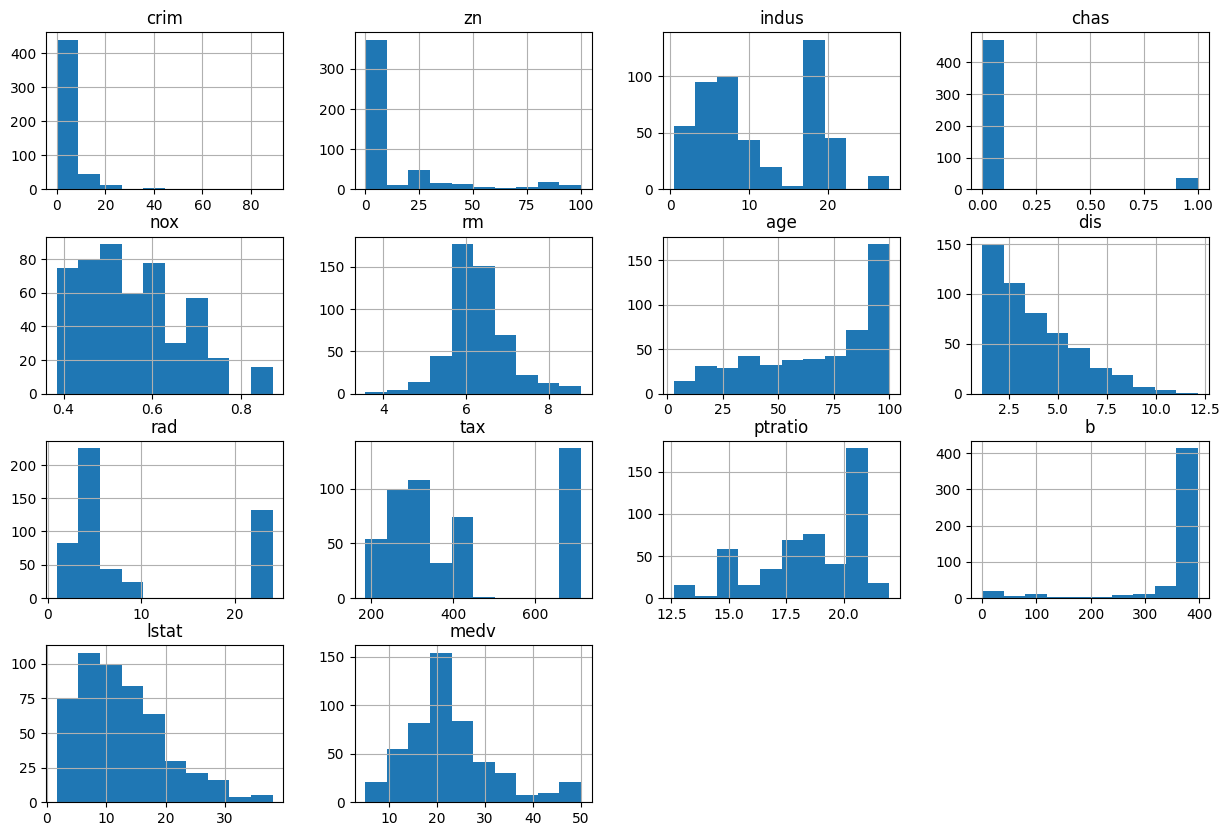

In [7]:
# распределения показателей

data.hist(figsize=(15, 10));

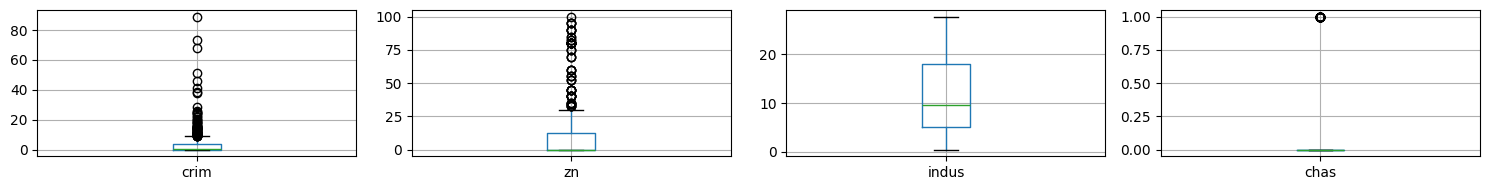

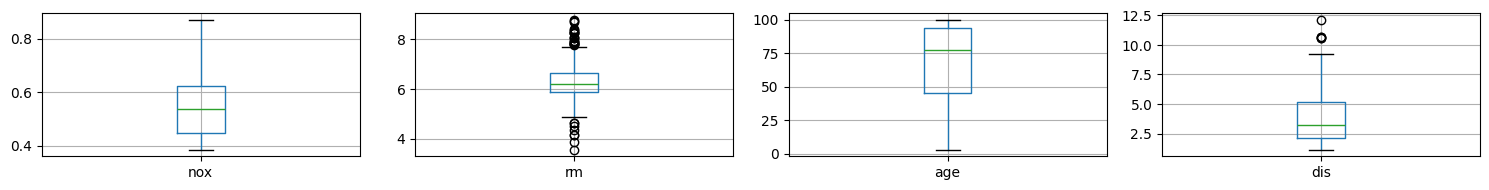

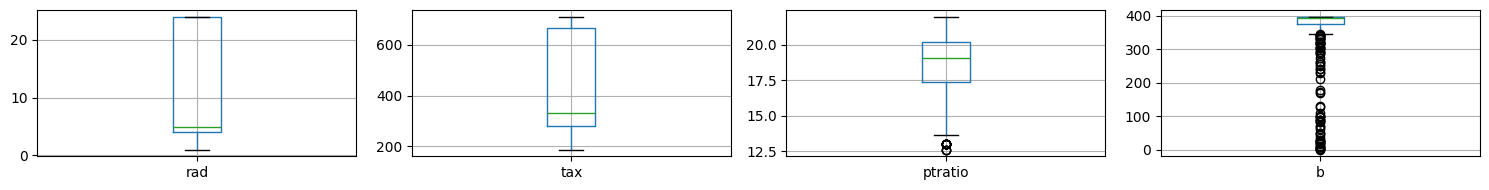

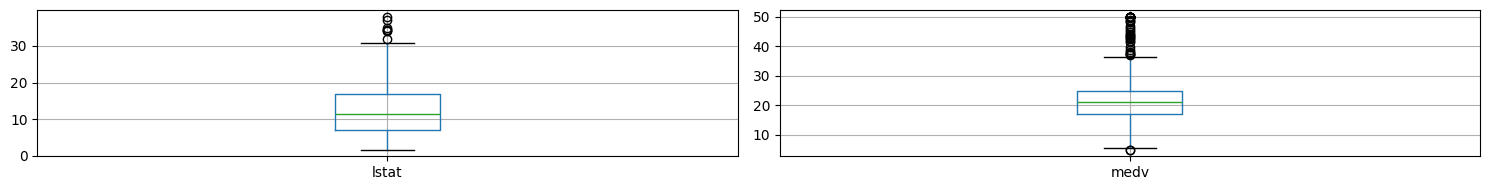

In [8]:
# проверка на выбросы

columns_list = data.columns.tolist()
for j in [0, 4, 8]:
    plt.figure(figsize=(15, 2))
    for i in range(4):
        plt.subplot(1, 4, i+1)
        data.boxplot(columns_list[i+j])
    plt.tight_layout()
    plt.show()

plt.figure(figsize=(15, 2))
for i in [1, 2]:
    plt.subplot(1, 2, i)
    data.boxplot(columns_list[i+11])
plt.tight_layout()
plt.show()

Выборосы могут быть у атрибутов CRIM, ZN, PTRATIO, LSTAT, B, а также у целевой переменной MEDV. У атрибута RM выборасы, скорее всего, просто хвосты. Посмотрим на потенциально неправильные объекты.

In [9]:
# хвост у crim
data.sort_values(by='crim').tail(10)

,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,b,lstat,medv
417,25.9406,0.0,18.1,0,0.679,5.304,89.1,1.6475,24,666,20.2,127.36,26.64,10.4
413,28.6558,0.0,18.1,0,0.597,5.155,100.0,1.5894,24,666,20.2,210.97,20.08,16.3
427,37.6619,0.0,18.1,0,0.679,6.202,78.7,1.8629,24,666,20.2,18.82,14.52,10.9
398,38.3518,0.0,18.1,0,0.693,5.453,100.0,1.4896,24,666,20.2,396.90,30.59,5.0
404,41.5292,0.0,18.1,0,0.693,5.531,85.4,1.6074,24,666,20.2,329.46,27.38,8.5
414,45.7461,0.0,18.1,0,0.693,4.519,100.0,1.6582,24,666,20.2,88.27,36.98,7.0
410,51.1358,0.0,18.1,0,0.597,5.757,100.0,1.4130,24,666,20.2,2.60,10.11,15.0
405,67.9208,0.0,18.1,0,0.693,5.683,100.0,1.4254,24,666,20.2,384.97,22.98,5.0
418,73.5341,0.0,18.1,0,0.679,5.957,100.0,1.8026,24,666,20.2,16.45,20.62,8.8
380,88.9762,0.0,18.1,0,0.671,6.968,91.9,1.4165,24,666,20.2,396.90,17.21,10.4


In [10]:
# хвост у zn
data.sort_values(by='zn').tail(10)

,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,b,lstat,medv
256,0.01538,90.0,3.75,0,0.3940,7.454,34.2,6.3361,3,244,15.9,386.34,3.11,44.0
284,0.00906,90.0,2.97,0,0.4000,7.088,20.8,7.3073,1,285,15.3,394.72,7.85,32.2
55,0.01311,90.0,1.22,0,0.4030,7.249,21.9,8.6966,5,226,17.9,395.93,4.81,35.4
353,0.01709,90.0,2.02,0,0.4100,6.728,36.1,12.1265,5,187,17.0,384.46,4.50,30.1
283,0.01501,90.0,1.21,1,0.4010,7.923,24.8,5.8850,1,198,13.6,395.52,3.16,50.0
203,0.03510,95.0,2.68,0,0.4161,7.853,33.2,5.1180,4,224,14.7,392.78,3.81,48.5
200,0.01778,95.0,1.47,0,0.4030,7.135,13.9,7.6534,3,402,17.0,384.30,4.45,32.9
199,0.03150,95.0,1.47,0,0.4030,6.975,15.3,7.6534,3,402,17.0,396.90,4.56,34.9
204,0.02009,95.0,2.68,0,0.4161,8.034,31.9,5.1180,4,224,14.7,390.55,2.88,50.0
57,0.01432,100.0,1.32,0,0.4110,6.816,40.5,8.3248,5,256,15.1,392.90,3.95,31.6


In [11]:
# хвост у ptratio
data.sort_values(by='ptratio').head(10)

,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,b,lstat,medv
197,0.04666,80.0,1.52,0,0.404,7.107,36.6,7.3090,2,329,12.6,354.31,8.61,30.3
198,0.03768,80.0,1.52,0,0.404,7.274,38.3,7.3090,2,329,12.6,392.20,6.62,34.6
196,0.04011,80.0,1.52,0,0.404,7.287,34.1,7.3090,2,329,12.6,396.90,4.08,33.3
262,0.52014,20.0,3.97,0,0.647,8.398,91.5,2.2885,5,264,13.0,386.86,5.91,48.8
261,0.53412,20.0,3.97,0,0.647,7.520,89.4,2.1398,5,264,13.0,388.37,7.26,43.1
264,0.55007,20.0,3.97,0,0.647,7.206,91.6,1.9301,5,264,13.0,387.89,8.10,36.5
265,0.76162,20.0,3.97,0,0.647,5.560,62.8,1.9865,5,264,13.0,392.40,10.45,22.8
266,0.78570,20.0,3.97,0,0.647,7.014,84.6,2.1329,5,264,13.0,384.07,14.79,30.7
263,0.82526,20.0,3.97,0,0.647,7.327,94.5,2.0788,5,264,13.0,393.42,11.25,31.0
268,0.54050,20.0,3.97,0,0.575,7.470,52.6,2.8720,5,264,13.0,390.30,3.16,43.5


In [12]:
# хвост у lstat
data.sort_values(by='lstat').tail(10)

,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,b,lstat,medv
384,20.08490,0.0,18.10,0,0.700,4.368,91.2,1.4395,24,666,20.2,285.83,30.63,8.8
48,0.25387,0.0,6.91,0,0.448,5.399,95.3,5.8700,3,233,17.9,396.90,30.81,14.4
385,16.81180,0.0,18.10,0,0.700,5.277,98.1,1.4261,24,666,20.2,396.90,30.81,7.2
387,22.59710,0.0,18.10,0,0.700,5.000,89.5,1.5184,24,666,20.2,396.90,31.99,7.4
438,13.67810,0.0,18.10,0,0.740,5.935,87.9,1.8206,24,666,20.2,68.95,34.02,8.4
412,18.81100,0.0,18.10,0,0.597,4.628,100.0,1.5539,24,666,20.2,28.79,34.37,17.9
141,1.62864,0.0,21.89,0,0.624,5.019,100.0,1.4394,4,437,21.2,396.90,34.41,14.4
373,11.10810,0.0,18.10,0,0.668,4.906,100.0,1.1742,24,666,20.2,396.90,34.77,13.8
414,45.74610,0.0,18.10,0,0.693,4.519,100.0,1.6582,24,666,20.2,88.27,36.98,7.0
374,18.49820,0.0,18.10,0,0.668,4.138,100.0,1.1370,24,666,20.2,396.90,37.97,13.8


In [13]:
# хвост у b
data.sort_values(by='b').tail(10)

,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,b,lstat,medv
307,0.04932,33.0,2.18,0,0.472,6.849,70.3,3.1827,7,222,18.4,396.9,7.53,28.2
308,0.49298,0.0,9.90,0,0.544,6.635,82.5,3.3175,4,304,18.4,396.9,4.54,22.8
311,0.79041,0.0,9.90,0,0.544,6.122,52.8,2.6403,4,304,18.4,396.9,5.98,22.1
317,0.24522,0.0,9.90,0,0.544,5.782,71.7,4.0317,4,304,18.4,396.9,15.94,19.8
320,0.16760,0.0,7.38,0,0.493,6.426,52.3,4.5404,5,287,19.6,396.9,7.20,23.8
321,0.18159,0.0,7.38,0,0.493,6.376,54.3,4.5404,5,287,19.6,396.9,6.87,23.1
322,0.35114,0.0,7.38,0,0.493,6.041,49.9,4.7211,5,287,19.6,396.9,7.70,20.4
324,0.34109,0.0,7.38,0,0.493,6.415,40.1,4.7211,5,287,19.6,396.9,6.12,25.0
295,0.12932,0.0,13.92,0,0.437,6.678,31.1,5.9604,4,289,16.0,396.9,6.27,28.6
505,0.04741,0.0,11.93,0,0.573,6.030,80.8,2.5050,1,273,21.0,396.9,7.88,11.9


In [14]:
# хвост у medv
data.sort_values(by='medv').head(10)

,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,b,lstat,medv
398,38.35180,0.0,18.10,0,0.693,5.453,100.0,1.4896,24,666,20.2,396.90,30.59,5.0
405,67.92080,0.0,18.10,0,0.693,5.683,100.0,1.4254,24,666,20.2,384.97,22.98,5.0
400,25.04610,0.0,18.10,0,0.693,5.987,100.0,1.5888,24,666,20.2,396.90,26.77,5.6
399,9.91655,0.0,18.10,0,0.693,5.852,77.8,1.5004,24,666,20.2,338.16,29.97,6.3
414,45.74610,0.0,18.10,0,0.693,4.519,100.0,1.6582,24,666,20.2,88.27,36.98,7.0
489,0.18337,0.0,27.74,0,0.609,5.414,98.3,1.7554,4,711,20.1,344.05,23.97,7.0
401,14.23620,0.0,18.10,0,0.693,6.343,100.0,1.5741,24,666,20.2,396.90,20.32,7.2
385,16.81180,0.0,18.10,0,0.700,5.277,98.1,1.4261,24,666,20.2,396.90,30.81,7.2
415,18.08460,0.0,18.10,0,0.679,6.434,100.0,1.8347,24,666,20.2,27.25,29.05,7.2
387,22.59710,0.0,18.10,0,0.700,5.000,89.5,1.5184,24,666,20.2,396.90,31.99,7.4


In [15]:
print('Количество объектов с medv меньше 10 тыс. долларов:',
      data[data['medv'] < 10]['crim'].count()
      )

Количество объектов с medv меньше 10 тыс. долларов: 24


Я не увидела здесь каких-то явных аномалий. Выросы из боксплотов выглядят просто как хвосты распределения, поэтому я оставила все объекты для дальнейшего анализа.

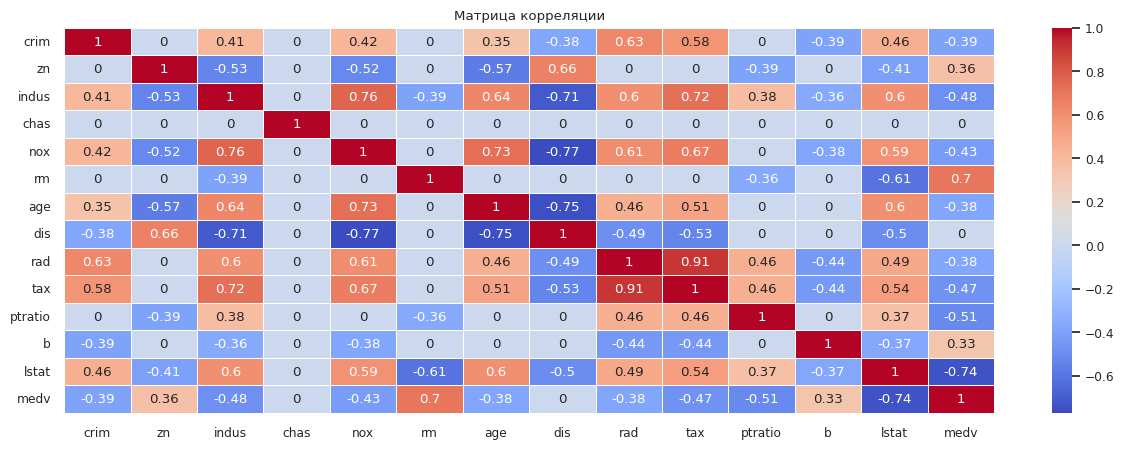

In [16]:
# проверим на мультиколлинеарность и посмотрим на влияние факторов на целевую переменную

plt.figure(figsize = (15,5))
sns.set(font_scale=0.8)

corr_matrix = np.round(data.corr(), 2)
corr_matrix[np.abs(corr_matrix) < 0.33] = 0

sns.heatmap(corr_matrix, annot=True, linewidths=.5, cmap='coolwarm')

plt.title('Матрица корреляции')
plt.show()

У TAX и RAD очень сильная корреляция, при этом TAX сильнее влияет на целевую переменную, поэтому оставим эту переменную для дальнейшего анализа.

Также в датасете есть еще пары показателей, у который связь достаточно сильна,
это:
- DIS - ZN
- DIS - INDUS
- DIS - NOX
- DIS - AGE

- NOX - INDUS
- NOX - AGE
- NOX - TAX

DIS можно спокойно убрать из анализа, посколько он почти не оказывает влияния на медианную цену. Также следует убрать NOX, поскольку он коррелирует с большим количеством других факторов. Также не информативным фактором является наличие рядом реки (CHAS). Этот фактор почти не оказывает влияния на целевую переменную, о чем свидетельствует почти нулевой коэффициент корреляции Пирсона.


## Обучение моделей

In [17]:
# функция обучения модели

def get_model(df, m):
  X = df.drop('medv', axis= 1)
  y = df['medv']
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
  model = m
  model.fit(X_train, y_train)
  y_pred = model.predict(X_train)
  mse = mean_squared_error(y_train, y_pred)
  r2 = r2_score(y_train, y_pred)
  return y_train, y_pred, mse, r2

# функция для вывода метрик и визуализовации
def get_metrics(y_train, y_pred, mse, r2):

    print("R2:", round(r2, 3))
    print("RMSE:", (round(np.sqrt(mse), 3)))
    print("MSE:", round(mse, 3))

    plt.figure(figsize=(5,5))

    sns.scatterplot(x=y_pred, y=y_train)
    plt.plot([-2, 3], [-2, 3], linestyle='--', color='black')

    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('True vs Predicted values')
    plt.show()


### Модели со всеми факторами

In [18]:
# копируем датафрейм
data_all = data.copy()

# cтандартизация
scaler = StandardScaler()
data_all[['crim', 'zn', 'indus', 'nox', 'rm',
          'age', 'dis', 'rad', 'tax', 'ptratio',
          'b', 'lstat', 'medv']] = scaler.fit_transform(data_all[['crim', 'zn', 'indus', 'nox', 'rm',
                                                                  'age', 'dis', 'rad', 'tax', 'ptratio',
                                                                  'b', 'lstat', 'medv']])

Линейная регрессия
R2: 0.751
RMSE: 0.506
MSE: 0.256


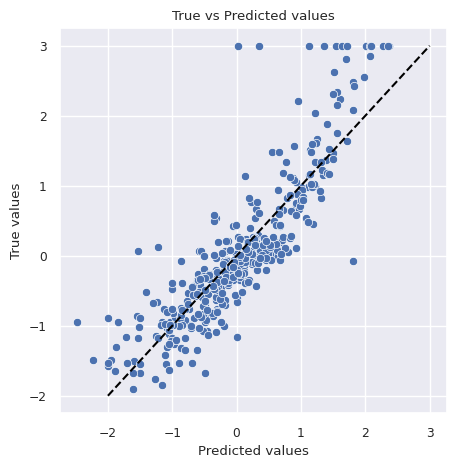

In [19]:
print('Линейная регрессия')

y_train_all_lr, y_pred_all_lr, mse_all_lr, r2_all_lr = get_model(data_all, LinearRegression())
get_metrics(y_train_all_lr, y_pred_all_lr, mse_all_lr, r2_all_lr)

Ridge-регрессия
R2: 0.751
RMSE: 0.506
MSE: 0.256


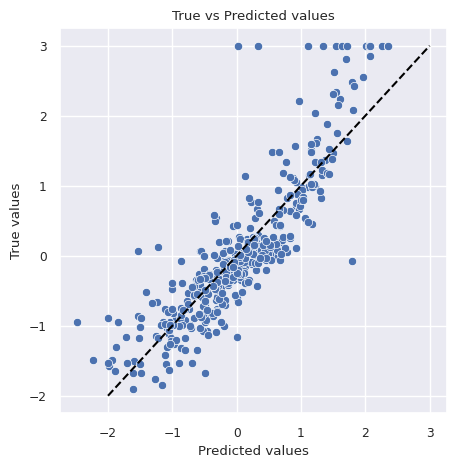

In [20]:
print('Ridge-регрессия')
y_train_all_r, y_pred_all_r, mse_all_r, r2_all_r = get_model(data_all, Ridge(alpha=1.0))
get_metrics(y_train_all_r, y_pred_all_r, mse_all_r, r2_all_r)

Обычная Lasso-регрессия
R2: 0.682
RMSE: 0.572
MSE: 0.327


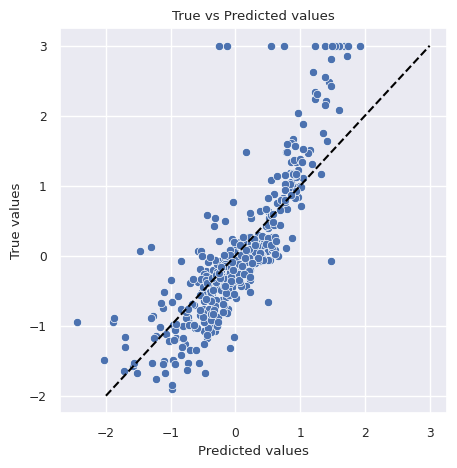

In [21]:
print('Обычная Lasso-регрессия')
y_train_all_l, y_pred_all_l, mse_all_l, r2_all_l = get_model(data_all, Lasso(alpha=0.1))
get_metrics(y_train_all_l, y_pred_all_l, mse_all_l, r2_all_l)

In [22]:
# подбор параметров для Lasso

X = data_all.drop('medv', axis= 1)
y = data_all['medv']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)

model = LassoCV(n_alphas=10, cv=cv, n_jobs=-1)

model.fit(X, y)

best_alpha = model.alpha_

print('Лучшее значение альфа:', round(best_alpha, 3))

Лучшее значение альфа: 0.003


Lasso-регрессия c лучшей альфа
R2: 0.75
RMSE: 0.507
MSE: 0.257


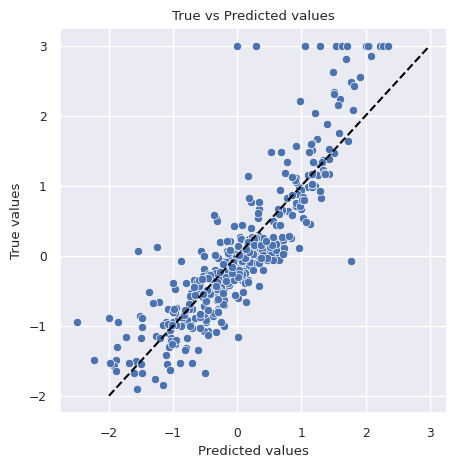

In [23]:
print('Lasso-регрессия c лучшей альфа')
y_train_all_l_alpha, y_pred_all_l_alpha, mse_all_l_alpha, r2_all_l_alpha = get_model(data_all, Lasso(alpha=best_alpha))
get_metrics(y_train_all_l_alpha, y_pred_all_l_alpha, mse_all_l_alpha, r2_all_l_alpha)

In [24]:
# Подберем лучшие параметры для дерева решений
X = data_all.drop('medv', axis= 1)
y = data_all['medv']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
model = DecisionTreeRegressor()

param_grid = {'max_depth': range(1, 10),
             'min_samples_leaf': range(1, 10)
}

grid_search = GridSearchCV(model, param_grid, cv=5)
grid_search.fit(X, y)

best_params = grid_search.best_params_
print("Лучшие параметры:", best_params)

Лучшие параметры: {'max_depth': 5, 'min_samples_leaf': 4}


Дерево решений
R2: 0.889
RMSE: 0.338
MSE: 0.114


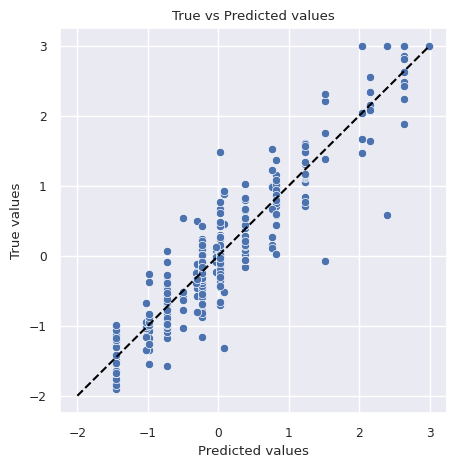

In [25]:
print('Дерево решений')
y_train_all_dtr, y_pred_all_dtr, mse_all_dtr, r2_all_dtr = get_model(data_all, DecisionTreeRegressor(max_depth=5,
                                                                                                     min_samples_leaf=4,
                                                                                                     random_state=42))
get_metrics(y_train_all_dtr, y_pred_all_dtr, mse_all_dtr, r2_all_dtr)

Случайный лес
R2: 0.902
RMSE: 0.317
MSE: 0.1


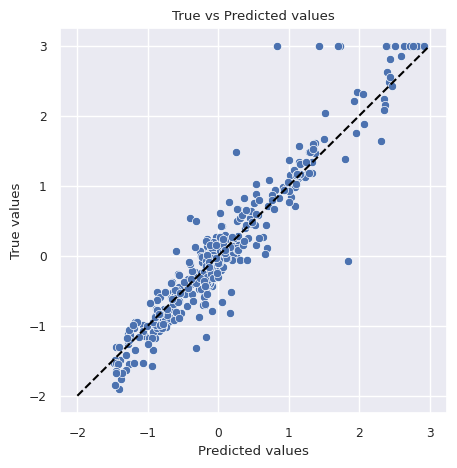

In [26]:
print('Случайный лес')

y_train_all_rf, y_pred_all_rf, mse_all_rf, r2_all_rf = get_model(data_all, RandomForestRegressor(max_depth=5,
                                                                                                     min_samples_leaf=4,
                                                                                                     random_state=42,
                                                                                                     n_estimators=100
)
)

get_metrics(y_train_all_rf, y_pred_all_rf, mse_all_rf, r2_all_rf)

### Модели после исключения мультиколлинеарности

In [27]:
# копируем датафрейм
data_clear = data.copy()

data_clear = data_clear.drop(['nox', 'dis', 'rad', 'chas'], axis=1)

# cтандартизация
scaler = StandardScaler()
data_clear[['crim', 'zn', 'indus', 'rm', 'age',
          'tax', 'ptratio', 'b', 'lstat', 'medv']] = scaler.fit_transform(data_clear[['crim', 'zn', 'indus', 'rm', 'age',
                                                                                    'tax', 'ptratio', 'b', 'lstat', 'medv']])

Линейная регрессия
R2: 0.708
RMSE: 0.548
MSE: 0.3


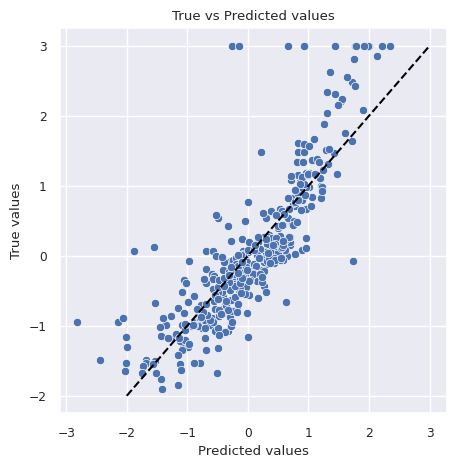

In [28]:
print('Линейная регрессия')

y_train_lr, y_pred_lr, mse_lr, r2_lr = get_model(data_clear, LinearRegression())
get_metrics(y_train_lr, y_pred_lr, mse_lr, r2_lr)

Ridge-регрессия
R2: 0.708
RMSE: 0.548
MSE: 0.3


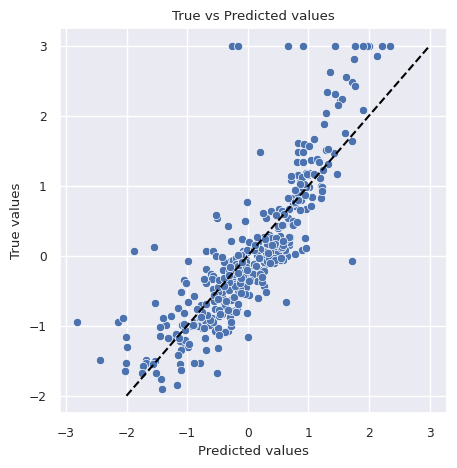

In [29]:
print('Ridge-регрессия')

y_train_r, y_pred_r, mse_r, r2_r = get_model(data_clear, Ridge(alpha=1.0))
get_metrics(y_train_r, y_pred_r, mse_r, r2_r)

Обычная Lasso-регрессия
R2: 0.682
RMSE: 0.572
MSE: 0.327


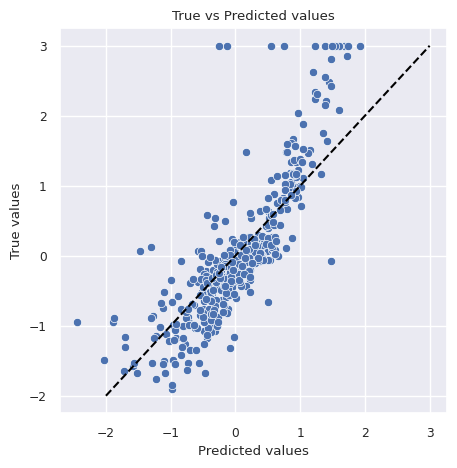

In [30]:
print('Обычная Lasso-регрессия')

y_train_l, y_pred_l, mse_l, r2_l = get_model(data_clear, Lasso(alpha=0.1))
get_metrics(y_train_l, y_pred_l, mse_l, r2_l)

In [31]:
# подбор параметров для Lasso

X = data_clear.drop('medv', axis= 1)
y = data_clear['medv']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
model = LassoCV(n_alphas=10, cv=cv, n_jobs=-1)
model.fit(X, y)
best_alpha = model.alpha_
print('Лучшее значение альфа:', round(best_alpha, 3))

Лучшее значение альфа: 0.034


Lasso-регрессия c лучшей альфа
R2: 0.701
RMSE: 0.555
MSE: 0.308


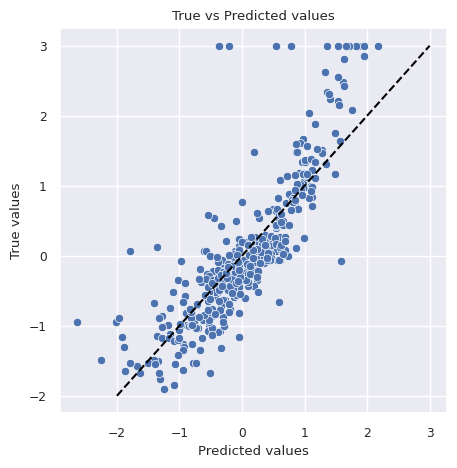

In [32]:
print('Lasso-регрессия c лучшей альфа')

y_train_l_alpha, y_pred_l_alpha, mse_l_alpha, r2_l_alpha = get_model(data_clear, Lasso(alpha=best_alpha))
get_metrics(y_train_l_alpha, y_pred_l_alpha, mse_l_alpha, r2_l_alpha)

In [33]:
# Подберем лучшие параметры для дерева решений
model = DecisionTreeRegressor()
param_grid = {'max_depth': range(1, 10),
             'min_samples_leaf': range(1, 10)
}
grid_search = GridSearchCV(model, param_grid, cv=5)
grid_search.fit(X, y)
best_params = grid_search.best_params_
print("Лучшие параметры:", best_params)

Лучшие параметры: {'max_depth': 6, 'min_samples_leaf': 7}


Дерево решений
R2: 0.858
RMSE: 0.382
MSE: 0.146


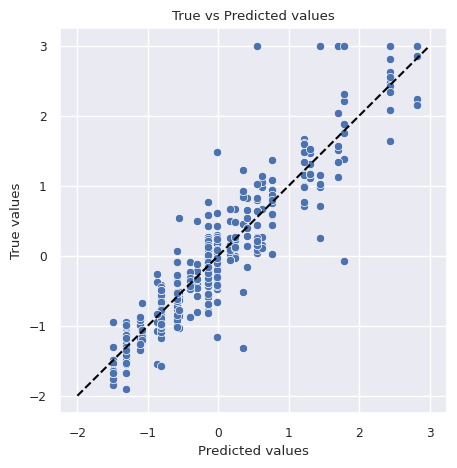

In [34]:
print('Дерево решений')

y_train_dtr, y_pred_dtr, mse_dtr, r2_dtr = get_model(data_clear, DecisionTreeRegressor(max_depth=6,
                                                                                       min_samples_leaf=7,
                                                                                       random_state=42))
get_metrics(y_train_dtr, y_pred_dtr, mse_dtr, r2_dtr)

Случайный лес
R2: 0.878
RMSE: 0.355
MSE: 0.126


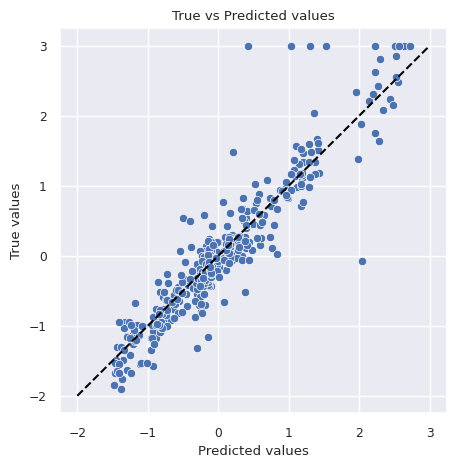

In [35]:
print('Случайный лес')

y_train_rf, y_pred_rf, mse_rf, r2_rf = get_model(data_clear, RandomForestRegressor(max_depth=6,
                                                                                   min_samples_leaf=7,
                                                                                   random_state=42,
                                                                                   n_estimators=100
)
)

get_metrics(y_train_rf, y_pred_rf, mse_rf, r2_rf)

## Сравнение моделей

In [36]:
total_metrics = pd.DataFrame(
    {'Модель': ['Линейная регрессия (все фичи)', 'Ridge-регрессия (все фичи)',
               'Обычная Lasso-регрессия (все фичи)','Lasso-регрессия c лучшей альфа (все фичи)',
               'Дерево решений (все фичи)','Случайный лес (все фичи)','Линейная регрессия',
               'Ridge-регрессия','Обычная Lasso-регрессия','Lasso-регрессия c лучшей альфа',
               'Дерево решений','Случайный лес'],
    'MSE': [mse_all_lr, mse_all_r, mse_all_l, mse_all_l_alpha, mse_all_dtr,
            mse_all_rf, mse_lr, mse_r, mse_l, mse_l_alpha, mse_dtr, mse_rf],
    'R2': [r2_all_lr, r2_all_r, r2_all_l, r2_all_l_alpha, r2_all_dtr,
           r2_all_rf, r2_lr, r2_r, r2_l, r2_l_alpha, r2_dtr, r2_rf]
}
)

In [37]:
total_metrics.sort_values(by='R2', ascending=False)

,Модель,MSE,R2
5,Случайный лес (все фичи),0.100410,0.902426
4,Дерево решений (все фичи),0.114289,0.888939
11,Случайный лес,0.125833,0.877722
10,Дерево решений,0.146296,0.857837
0,Линейная регрессия (все фичи),0.256355,0.750886
1,Ridge-регрессия (все фичи),0.256377,0.750865
3,Lasso-регрессия c лучшей альфа (все фичи),0.257288,0.749980
6,Линейная регрессия,0.300170,0.708309
7,Ridge-регрессия,0.300172,0.708306
9,Lasso-регрессия c лучшей альфа,0.307545,0.701142


In [38]:
total_metrics.T

,0,1,2,3,4,5,6,7,8,9,10,11
Модель,Линейная регрессия (все фичи),Ridge-регрессия (все фичи),Обычная Lasso-регрессия (все фичи),Lasso-регрессия c лучшей альфа (все фичи),Дерево решений (все фичи),Случайный лес (все фичи),Линейная регрессия,Ridge-регрессия,Обычная Lasso-регрессия,Lasso-регрессия c лучшей альфа,Дерево решений,Случайный лес
MSE,0.256355,0.256377,0.327358,0.257288,0.114289,0.10041,0.30017,0.300172,0.327358,0.307545,0.146296,0.125833
R2,0.750886,0.750865,0.681888,0.74998,0.888939,0.902426,0.708309,0.708306,0.681888,0.701142,0.857837,0.877722


**Вывод:**

По итогу анализа мы получили ожидаемый ретийнг моделей. Лучше всего описывает дисперсию целевой переменной модель Случайный лес со всеми анализируемыми факторами. Также высокий коэффициент детерминации у Дерева решений по полному кругу факторов.

Но для прогнозирования стоимости домов я бы все же использовала модель на основе случайного леса или дерева решений по списку факторов после исключения мультиколлинеарности, чтобы избежать ошибок.

## Модели градиентного бустинга

In [39]:
data = pd.read_csv('https://raw.githubusercontent.com/selva86/datasets/master/BostonHousing.csv')

In [40]:
# функция обучения модели
def get_model(df, m):
  X = df.drop('medv', axis= 1)
  y = df['medv']
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
  model = m
  model.fit(X_train, y_train)
  y_pred = model.predict(X_train)
  mse = mean_squared_error(y_train, y_pred)
  r2 = r2_score(y_train, y_pred)
  return y_train, y_pred, mse, r2

# функция для вывода метрик
def get_metrics(y_train, y_pred, mse, r2):

    print("R2:", round(r2, 3))
    print("RMSE:", (round(np.sqrt(mse), 3)))
    print("MSE:", round(mse, 3))

In [41]:
# копируем датафрейм (для градиентного бустинга будем использовать очищенный датафрейм)
data_clear = data.copy()

data_clear = data_clear.drop(['nox', 'dis', 'rad', 'chas'], axis=1)

# cтандартизация
scaler = StandardScaler()
data_clear[['crim', 'zn', 'indus', 'rm', 'age',
          'tax', 'ptratio', 'b', 'lstat', 'medv']] = scaler.fit_transform(data_clear[['crim', 'zn', 'indus', 'rm', 'age',
                                                                                    'tax', 'ptratio', 'b', 'lstat', 'medv']])

X = data_clear.drop('medv', axis= 1)
y = data_clear['medv']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [42]:
# Подберем лучшие параметры для градиентного бустинга
model = GradientBoostingRegressor()

param_grid = {'n_estimators': [10, 50, 100],
              'max_depth': range(1, 10),
              'min_samples_leaf': range(1, 10)}

grid_search = GridSearchCV(model, param_grid, scoring='r2',
                           cv=KFold(n_splits=3, random_state=21, shuffle=True),
                           n_jobs=-1
                           )
grid_search.fit(X, y)

best_params = grid_search.best_params_
print("Лучшие параметры:", best_params)

Лучшие параметры: {'max_depth': 4, 'min_samples_leaf': 5, 'n_estimators': 100}


In [43]:
print('Градиентный бустинг')

y_train_gb, y_pred_gb, mse_gb, r2_gb = get_model(data_clear,
                                                 GradientBoostingRegressor(max_depth=4,
                                                                           min_samples_leaf=5,
                                                                           random_state=42,
                                                                           n_estimators=100)
                                                 )
get_metrics(y_train_gb, y_pred_gb, mse_gb, r2_gb)

Градиентный бустинг
R2: 0.982
RMSE: 0.134
MSE: 0.018


In [44]:
print('XGboost')
y_train_xb, y_pred_xb, mse_xb, r2_xb = get_model(data_clear,
                                                 xgb.XGBRegressor(objective='reg:squarederror',
                                                                  n_estimators=50,
                                                                  learning_rate=0.2)
                                                 )
get_metrics(y_train_xb, y_pred_xb, mse_xb, r2_xb)

XGboost
R2: 0.998
RMSE: 0.04
MSE: 0.002


In [45]:
print('LighGBM')
y_train_light, y_pred_light, mse_light, r2_light = get_model(data_clear,
                                                 lgb.LGBMRegressor(objective='regression', n_estimators=50, learning_rate=0.2))

get_metrics(y_train_light, y_pred_light, mse_light, r2_light)

LighGBM
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000879 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 777
[LightGBM] [Info] Number of data points in the train set: 404, number of used features: 9
[LightGBM] [Info] Start training from score 0.028704
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive g

In [46]:
print('Catboost')
y_train_cat, y_pred_cat, mse_cat, r2_cat = get_model(data_clear,
                                                 cb.CatBoostRegressor(verbose=0)
                                                 )

get_metrics(y_train_cat, y_pred_cat, mse_cat, r2_cat)

Catboost
R2: 0.995
RMSE: 0.07
MSE: 0.005


In [47]:
# сравнение метрик
boosting_metrics = pd.DataFrame(
    {'Модель': ['SKlearn', 'XGboost', 'LighGBM', 'Catboost'],
    'MSE': [mse_gb, mse_xb, mse_light, mse_cat],
    'R2': [r2_gb, r2_xb, r2_light, r2_cat]
}
)
boosting_metrics['MSE'] = boosting_metrics['MSE'].apply(lambda x: round(x, 3 ))

metrics = pd.concat([total_metrics, boosting_metrics])
metrics.sort_values(by='R2', ascending=False)

,Модель,MSE,R2
1,XGboost,0.002000,0.998441
3,Catboost,0.005000,0.995203
0,SKlearn,0.018000,0.982465
2,LighGBM,0.030000,0.971234
5,Случайный лес (все фичи),0.100410,0.902426
4,Дерево решений (все фичи),0.114289,0.888939
11,Случайный лес,0.125833,0.877722
10,Дерево решений,0.146296,0.857837
0,Линейная регрессия (все фичи),0.256355,0.750886
1,Ridge-регрессия (все фичи),0.256377,0.750865


**Вывод:**

Catboost и XGboost получились переобученными, видимо, нужно более тщательно поработать с параметрами. У SKlearn и LighGBM получились лучше метрики, но тоже слишком высокие. В целом метрики выше, чем у случайного леса и дерева решений.